In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import pickle
import json
import sys
sys.path.append('..')
import utils

IMAGE_SIZE = 1024
DATASET_PATH = '../mvtec_anomaly_detection_data'

In [ ]:
annotations = utils.annotate_dataset(DATASET_PATH)
utils.create_annotation_files(annotations)

In [2]:
def inv_dict(d):
    return dict((v, k) for k, v in d.items())

to_load = 'transistor'

object_dict = utils.get_object_dict(DATASET_PATH)
class_dict = utils.get_class_dict(DATASET_PATH, to_load)

anot = inv_dict(object_dict)

dataset = utils.load_annotation_file(f'{anot[to_load]}')
random.shuffle(dataset)
#train_ds, test_ds, val_ds = utils.train_test_split_annotations(dataset, 0.6, 0)
train_ds, test_ds, val_ds = utils.train_test_split_annotations_even(dataset, 0.6, 0)

In [3]:
class_dict

{1: 'bent_lead', 2: 'cut_lead', 3: 'damaged_case', 4: 'misplaced'}

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
class MVTEC_Dataset(Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()       
        
        self.dataset = dataset
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        data = self.dataset[index]
        
        image = cv2.imread(data[2])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        bbox = list(data[1])
        bbox[0] = bbox[0] * IMAGE_SIZE
        bbox[1] = bbox[1] * IMAGE_SIZE
        bbox[2] = bbox[2] * IMAGE_SIZE + bbox[0]
        bbox[3] = bbox[3] * IMAGE_SIZE + bbox[1]
        bbox = [int(x) for x in bbox]
        area = bbox[2] * bbox[3]
        
        labels = torch.as_tensor([int(data[0])], dtype=torch.int64)
        
        iscrowd = torch.zeros([0], dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.Tensor([bbox])
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.Tensor([area])
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
            ])
            image = transform(image)
        
        return image, target, index
    
    def __len__(self) -> int:
        return len(self.dataset)

In [6]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.RandomRotate90(p=0.5),
        A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [7]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [8]:
num_classes = len(class_dict) + 1

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MVTEC_Dataset(train_ds, get_train_transform())
test_dataset = MVTEC_Dataset(test_ds, None)
val_dataset = MVTEC_Dataset(val_ds, get_valid_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

"""
test_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)
"""

valid_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

In [11]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [12]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1]

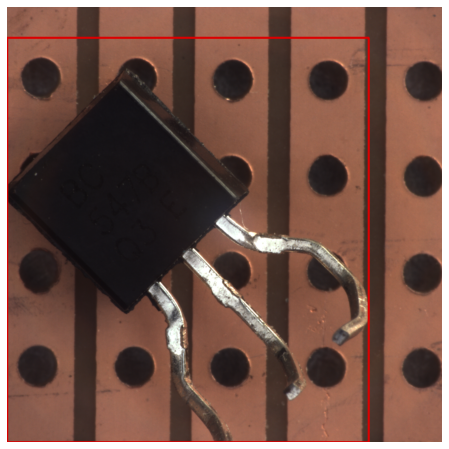

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = np.array(torchvision.transforms.ToPILImage()(sample))

for box in boxes:
    cv2.rectangle(sample,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [14]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 100

In [15]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Epoch #0 loss: 0.5425442309635228
Epoch #1 loss: 0.29225697842781345
Epoch #2 loss: 0.23871352978598145
Epoch #3 loss: 0.2509026581010873
Iteration #50 loss: 0.2194116396049503
Epoch #4 loss: 0.2279145659188859
Epoch #5 loss: 0.25343231295128466
Epoch #6 loss: 0.23406016307976837
Epoch #7 loss: 0.21167774679801066
Iteration #100 loss: 0.18412189706184884
Epoch #8 loss: 0.2303052852068573
Epoch #9 loss: 0.22872017986216955
Epoch #10 loss: 0.20735427264806514
Epoch #11 loss: 0.2184018964707551
Iteration #150 loss: 0.17921030076058886
Epoch #12 loss: 0.2331805168850137
Epoch #13 loss: 0.21280830126202055
Epoch #14 loss: 0.22678156397030716
Epoch #15 loss: 0.20924124896857624
Iteration #200 loss: 0.24258912271506075
Epoch #16 loss: 0.21750401655506427
Epoch #17 loss: 0.2067499936017054
Epoch #18 loss: 0.17444647322974674
Epoch #19 loss: 0.17756157021828575
Iteration #250 loss: 0.1331403920548975
Epoch #20 loss: 0.16735009390334724
Epoch #21 loss: 0.17940727963946898
Epoch #22 loss: 0.15271

In [16]:
images, targets, image_ids = next(iter(valid_data_loader))

In [17]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [18]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0]

In [19]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [20]:
outputs

[{'boxes': tensor([[487.3994, 504.4518, 719.4659, 628.1880]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([3]),
  'scores': tensor([0.1835], grad_fn=<ToCopyBackward0>)}]

In [21]:
boxes = [outputs[0]['boxes'][0].detach().numpy().astype(np.int32)]
label = class_dict[outputs[0]['labels'].detach().numpy()[0]]

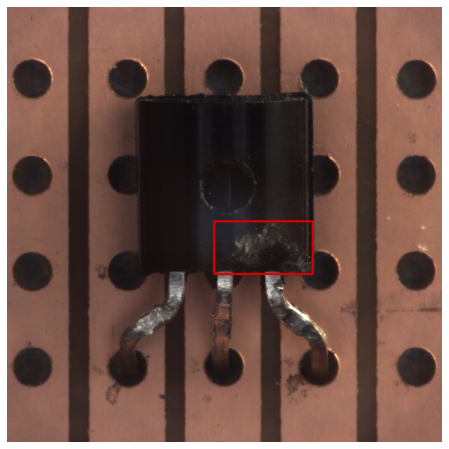

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = np.array(torchvision.transforms.ToPILImage()(sample))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [23]:
print(f"Predicted label: {label}")
actual_label = class_dict[targets[0]['labels'].cpu().numpy()[0]]
print(f'Actual label: {actual_label}')

Predicted label: damaged_case
Actual label: damaged_case


In [24]:
class_dict

{1: 'bent_lead', 2: 'cut_lead', 3: 'damaged_case', 4: 'misplaced'}

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for images, targets, image_ids in valid_data_loader:
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    exclude = []
    
    #print(outputs)
    pred_labels = []
    for i, item in enumerate(outputs):
        if item['labels'].cpu().numpy().size == 0:
            exclude.append(i)
            continue
        print(item['labels'].cpu().numpy())
        pred_labels.append(item['labels'][0].cpu().numpy())
    y_pred.extend(pred_labels)
    
    true_labels = []
    for i, item in enumerate(targets):
        if i in exclude:
            continue
        true_labels.append(item['labels'][0].cpu().numpy())
    y_true.extend(true_labels)

[4 2]
[3 3 4]
[4 1]
[3]
[4]
[2 4]
[1]
[4]
[4]
[4]
[2 4]
[3]
[4 3 4]
[2 2 4 2 1]


In [26]:
for a, b in zip(y_pred, y_true):
    print('{} | {}'.format(a, b))

4 | 4
3 | 3
4 | 4
3 | 3
4 | 1
2 | 2
1 | 1
4 | 1
4 | 1
4 | 2
2 | 2
3 | 3
4 | 3
2 | 2


In [27]:
class_dict

{1: 'bent_lead', 2: 'cut_lead', 3: 'damaged_case', 4: 'misplaced'}

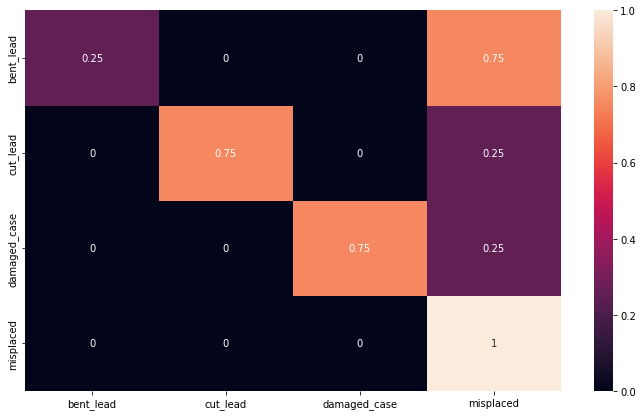

In [28]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize = 'true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_dict.values()], columns = [i for i in class_dict.values()])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')